In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [274]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [4]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [5]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [7]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [8]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [9]:
def DetailBasedNthDay(dataframe, nthday=1):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [10]:
learn_detail = DetailBasedNthDay(detail, nthday=1)

In [11]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [12]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 13)

In [13]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 14)

In [14]:
engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')


brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [15]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [16]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 17)

In [17]:
action = DetailBasedNthDay(engage, nthday=1)

In [18]:
action.shape

(336340, 20)

In [20]:
Recency = lambda x: 2 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

# Mode_firstuse_hour = lambda x: x.mode()[0]
# Mode_lastuse_day = lambda x: x.mode()[0]
# Mode_lastuse_hour = lambda x: x.mode()[0]
# Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords']

active.columns = cols

In [21]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [22]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [23]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [24]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [26]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 6)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [27]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 41)

In [29]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 41)

In [275]:
data = final.copy()

In [276]:
data = pd.merge(left=data,
                right=df_pay[['UserID', 'JoinMonth']],
                how='left',
                on='UserID')
data.shape

(158981, 42)

In [277]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [278]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [279]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [280]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [281]:
data1 = data.copy()

In [282]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

----- TotalUsageTime -----
count    158981.000000
mean          2.455485
std           1.183931
min           0.000000
25%           1.515127
50%           2.537657
75%           3.350956
max           7.078611
Name: TotalUsageTime, dtype: float64
* Variance: 1.4016935864129958
* Median: 2.5376572151735295
* Skewness: -0.03920504402125023
* Kurtosis: -0.8127449892550369
* Percentage of outliers: 5.6610538366219865e-05
* Number of missing value: 0


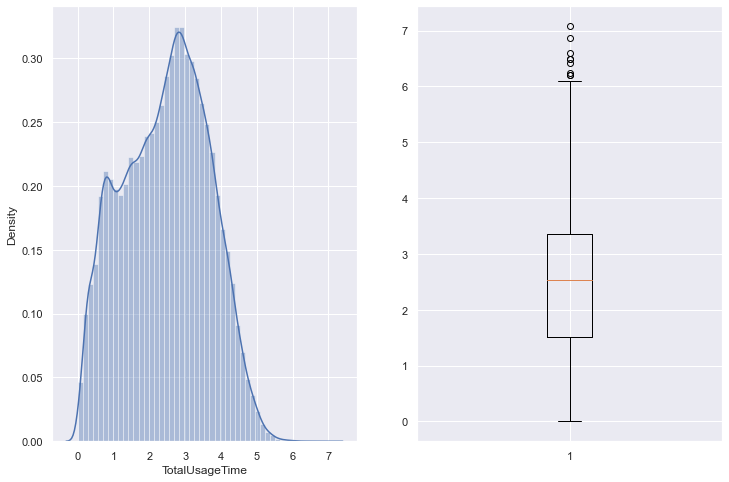


----- TotalRecords -----
count    158981.000000
mean          2.351732
std           1.234208
min           0.000000
25%           1.386294
50%           2.484907
75%           3.295837
max           6.311735
Name: TotalRecords, dtype: float64
* Variance: 1.5232686082727207
* Median: 2.4849066497880004
* Skewness: -0.2509948882162156
* Kurtosis: -0.6986479320297221
* Percentage of outliers: 6.290059818468873e-06
* Number of missing value: 0


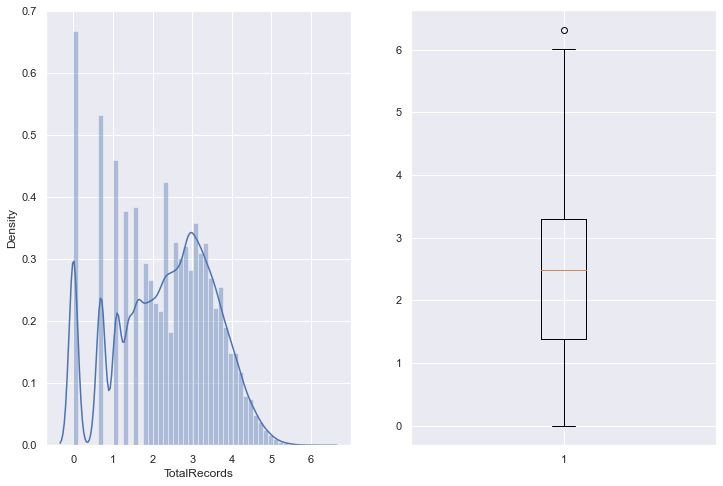


----- InteractionEnglish -----
count    158981.000000
mean          1.952449
std           2.361872
min           0.000000
25%           0.000000
50%           0.576613
75%           4.070564
max          11.664985
Name: InteractionEnglish, dtype: float64
* Variance: 5.578440529181716
* Median: 0.5766133643039938
* Skewness: 0.7962279242761756
* Kurtosis: -0.798645957041177
* Percentage of outliers: 7.548071782162648e-05
* Number of missing value: 0


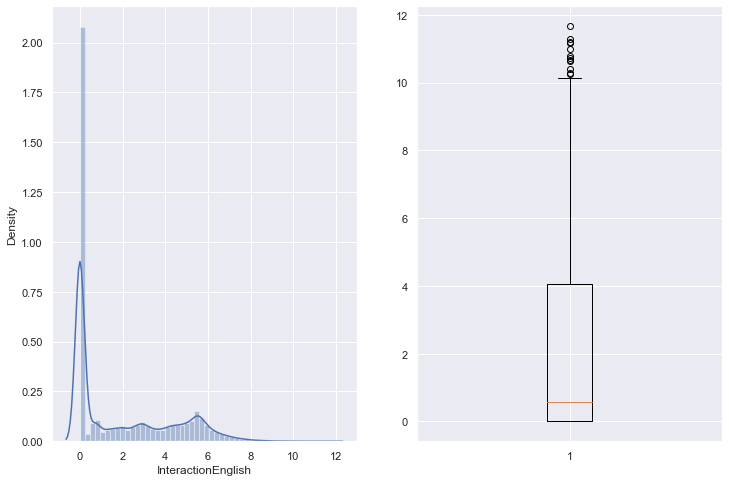


----- InteractionMath -----
count    158981.000000
mean          0.065885
std           0.538871
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.701298
Name: InteractionMath, dtype: float64
* Variance: 0.29038228056037735
* Median: 0.0
* Skewness: 9.704494398732523
* Kurtosis: 102.74335602406661
* Percentage of outliers: 0.0238456167718155
* Number of missing value: 0


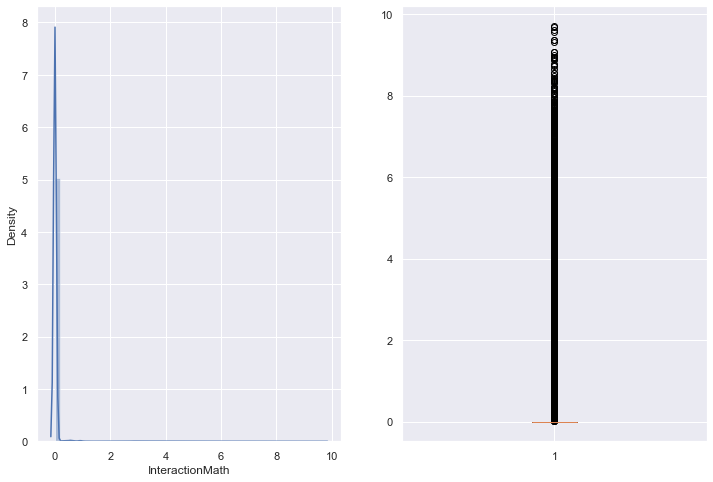


----- InteractionPhonics -----
count    158981.000000
mean          0.070404
std           0.532213
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.062838
Name: InteractionPhonics, dtype: float64
* Variance: 0.28325111262231983
* Median: 0.0
* Skewness: 8.930838206188215
* Kurtosis: 86.93068756958027
* Percentage of outliers: 0.02497153747932143
* Number of missing value: 0


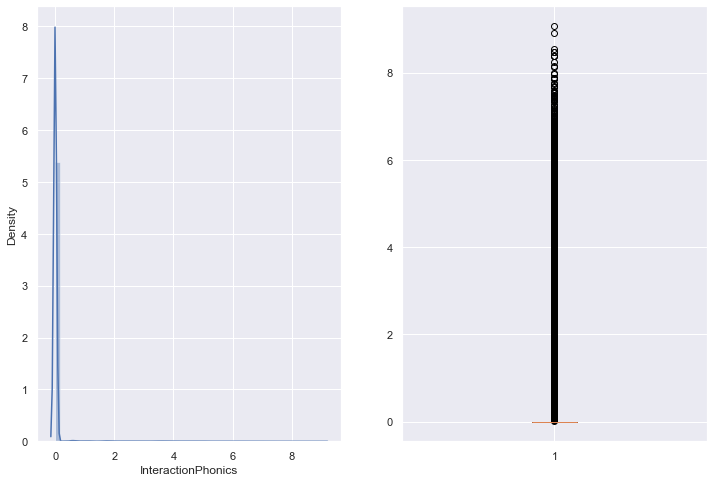


----- InteractionVietnamese -----
count    158981.000000
mean          2.077620
std           2.499071
min           0.000000
25%           0.000000
50%           0.641854
75%           4.143928
max          11.397071
Name: InteractionVietnamese, dtype: float64
* Variance: 6.245357188082897
* Median: 0.6418538861723947
* Skewness: 0.8490616587426203
* Kurtosis: -0.6481243559272105
* Percentage of outliers: 0.0001195111365509086
* Number of missing value: 0


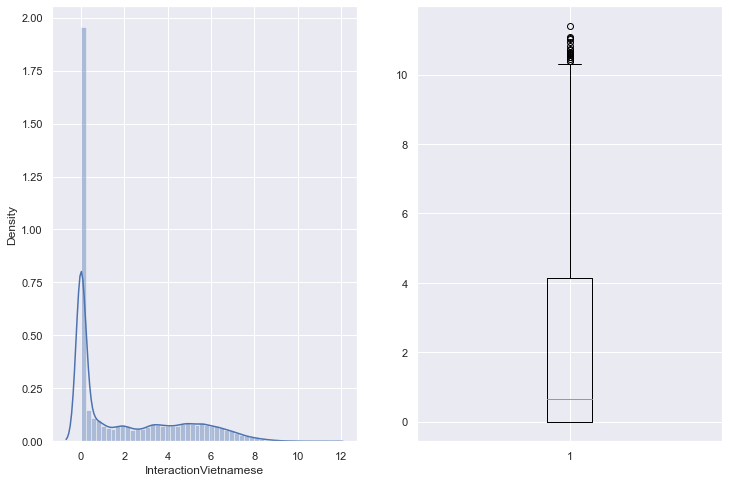


----- IsCompletedEnglish -----
count    158981.000000
mean          0.401165
std           0.416745
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.098612
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.1736765256888231
* Median: 0.6931471805599453
* Skewness: 0.2828658364329821
* Kurtosis: -1.487835402351314
* Percentage of outliers: 0.0
* Number of missing value: 0


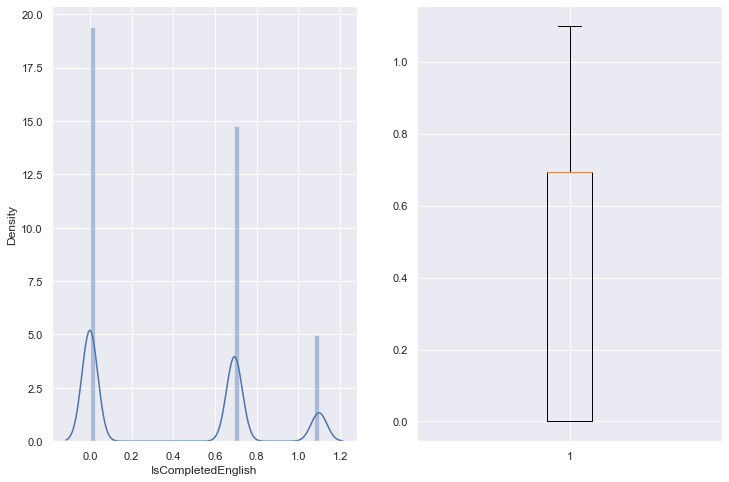


----- IsCompletedMath -----
count    158981.000000
mean          0.016569
std           0.113442
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.098612
Name: IsCompletedMath, dtype: float64
* Variance: 0.012869069451352041
* Median: 0.0
* Skewness: 7.047545796845342
* Kurtosis: 50.602018910089086
* Percentage of outliers: 0.02172586661299149
* Number of missing value: 0


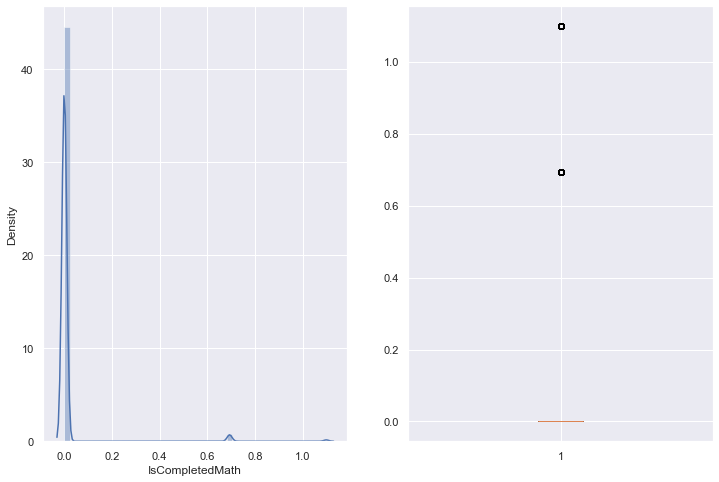


----- IsCompletedPhonics -----
count    158981.000000
mean          0.016964
std           0.113886
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.098612
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.012970080329985237
* Median: 0.0
* Skewness: 6.886174280594748
* Kurtosis: 48.17115465754807
* Percentage of outliers: 0.02250583403048163
* Number of missing value: 0


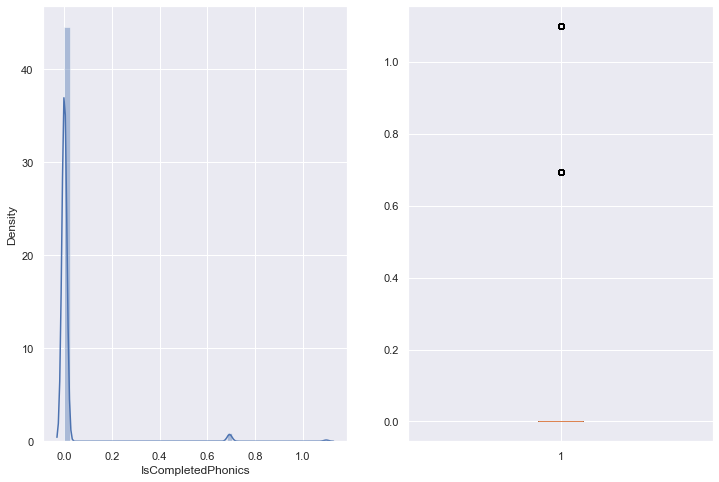


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.414726
std           0.420230
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.098612
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.176593106202271
* Median: 0.6931471805599453
* Skewness: 0.23893900944255622
* Kurtosis: -1.5069244824378474
* Percentage of outliers: 0.0
* Number of missing value: 0


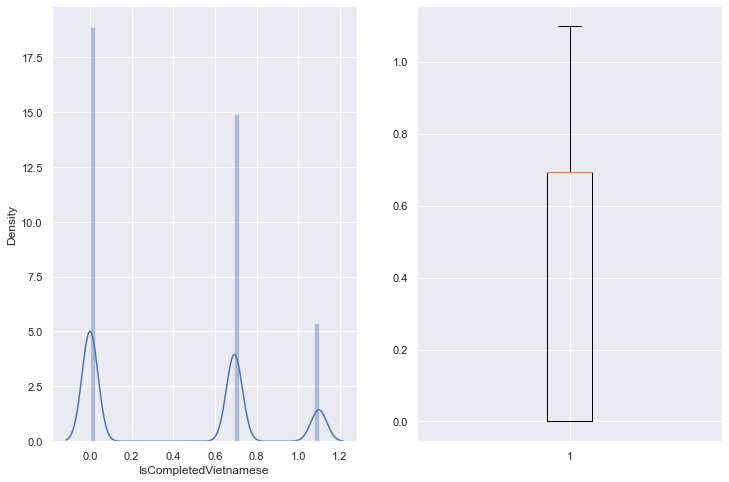


----- RecordEnglish -----
count    158981.000000
mean          1.208349
std           1.347555
min           0.000000
25%           0.000000
50%           0.693147
75%           2.397895
max           5.799093
Name: RecordEnglish, dtype: float64
* Variance: 1.8159042242367502
* Median: 0.6931471805599453
* Skewness: 0.5930429632035079
* Kurtosis: -1.0805899943001005
* Percentage of outliers: 0.0
* Number of missing value: 0


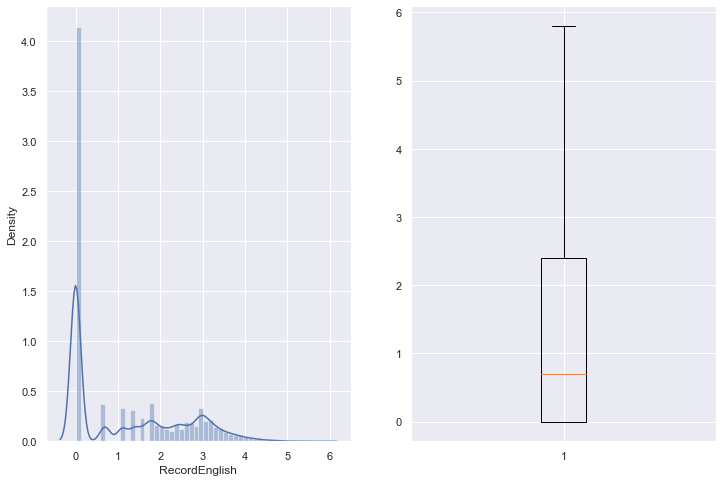


----- RecordMath -----
count    158981.000000
mean          0.043562
std           0.312328
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.762174
Name: RecordMath, dtype: float64
* Variance: 0.09754872554491147
* Median: 0.0
* Skewness: 8.255435604923365
* Kurtosis: 74.07902194844964
* Percentage of outliers: 0.023864486951270907
* Number of missing value: 0


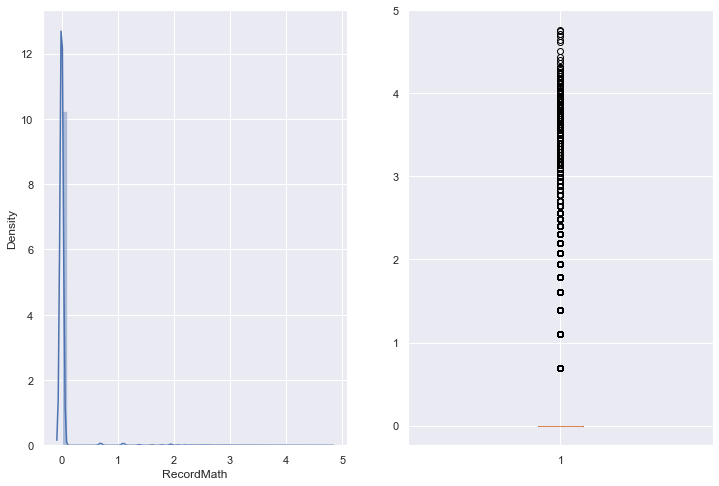


----- RecordPhonics -----
count    158981.000000
mean          0.044807
std           0.310490
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.017280
Name: RecordPhonics, dtype: float64
* Variance: 0.09640418845923887
* Median: 0.0
* Skewness: 7.925653249186303
* Kurtosis: 68.19092408246453
* Percentage of outliers: 0.025002987778413772
* Number of missing value: 0


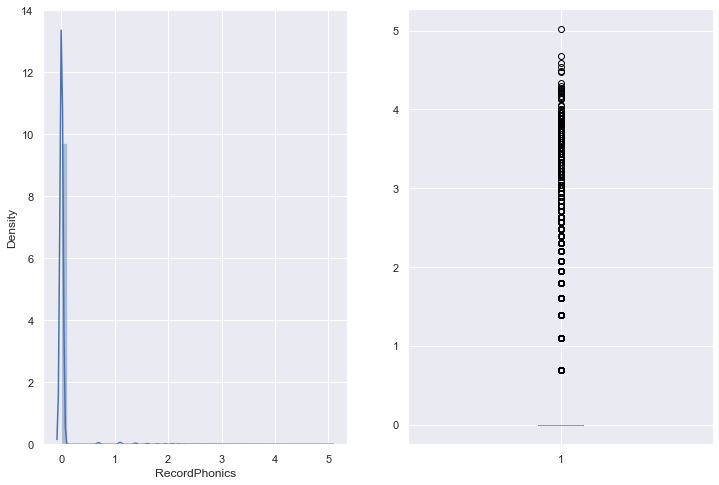


----- RecordVietnamese -----
count    158981.000000
mean          1.242317
std           1.351693
min           0.000000
25%           0.000000
50%           0.693147
75%           2.302585
max           6.054439
Name: RecordVietnamese, dtype: float64
* Variance: 1.8270743629604302
* Median: 0.6931471805599453
* Skewness: 0.6807343751612923
* Kurtosis: -0.8137056995419538
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


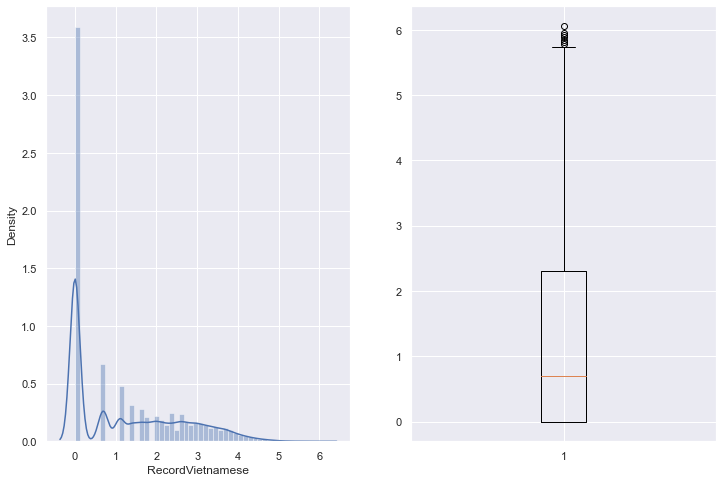


----- UsageTimeEnglish -----
count    158981.000000
mean          1.061530
std           1.232506
min           0.000000
25%           0.000000
50%           0.559616
75%           2.125848
max           7.019967
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.5190709206804043
* Median: 0.5596157879354227
* Skewness: 0.7460162249929259
* Kurtosis: -0.7519557015012426
* Percentage of outliers: 0.00020757197400947283
* Number of missing value: 0


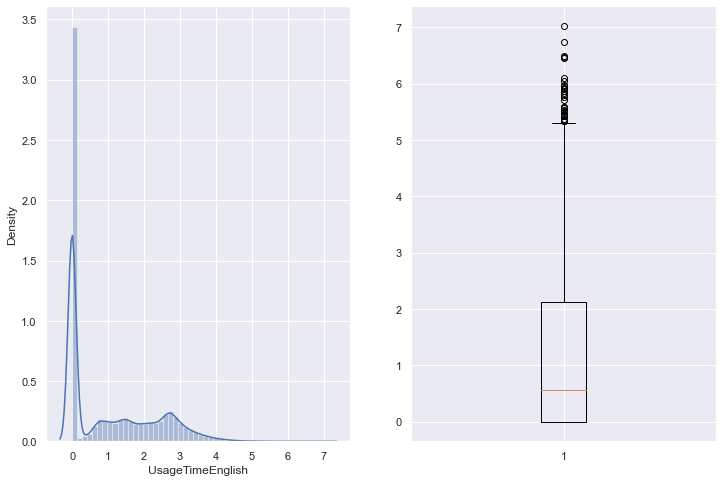


----- UsageTimeMath -----
count    158981.000000
mean          0.037718
std           0.297399
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.889902
Name: UsageTimeMath, dtype: float64
* Variance: 0.08844629358899095
* Median: 0.0
* Skewness: 9.531589015916481
* Kurtosis: 100.75754895420282
* Percentage of outliers: 0.0238456167718155
* Number of missing value: 0


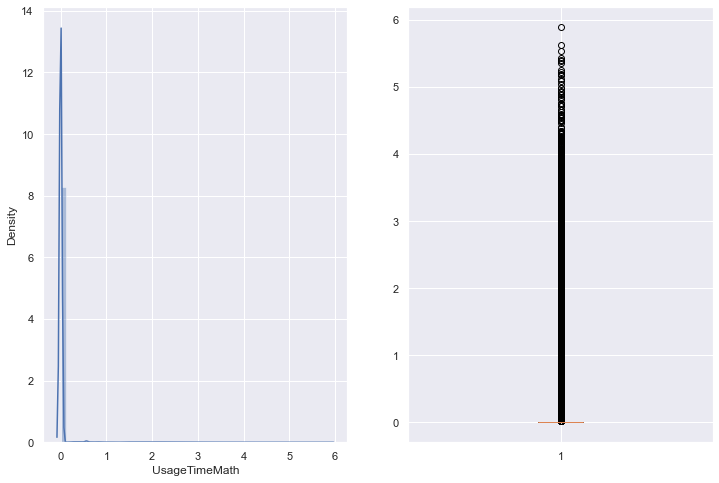


----- UsageTimePhonics -----
count    158981.000000
mean          0.042845
std           0.304186
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.853981
Name: UsageTimePhonics, dtype: float64
* Variance: 0.09252886314951227
* Median: 0.0
* Skewness: 8.153655472407866
* Kurtosis: 72.13837083173843
* Percentage of outliers: 0.02497153747932143
* Number of missing value: 0


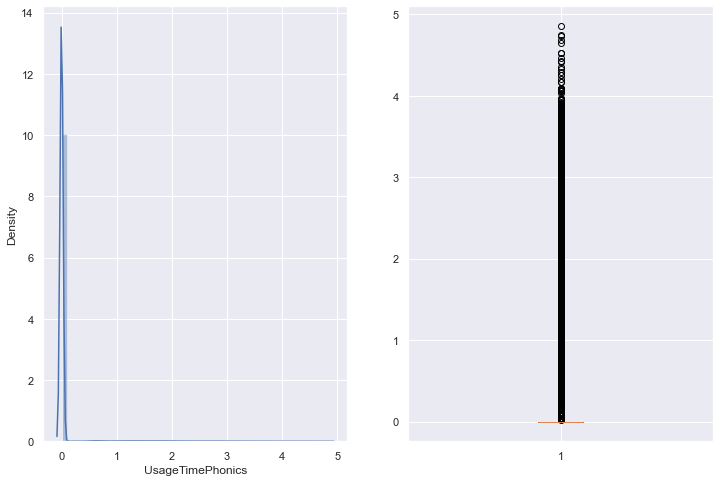


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.164994
std           1.324640
min           0.000000
25%           0.000000
50%           0.587787
75%           2.288486
max           6.220352
Name: UsageTimeVietnamese, dtype: float64
* Variance: 1.7546711547039369
* Median: 0.587786664902119
* Skewness: 0.737909369879308
* Kurtosis: -0.7958108879075345
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


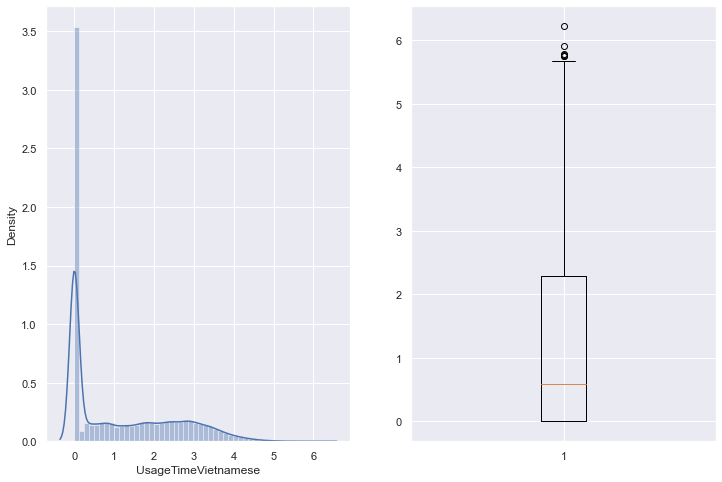


----- RecordDiscovery -----
count    158981.000000
mean          0.498411
std           0.784418
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.087596
Name: RecordDiscovery, dtype: float64
* Variance: 0.6153117988770085
* Median: 0.0
* Skewness: 1.4161906784193077
* Kurtosis: 0.89526721428828
* Percentage of outliers: 0.1162780458042156
* Number of missing value: 0


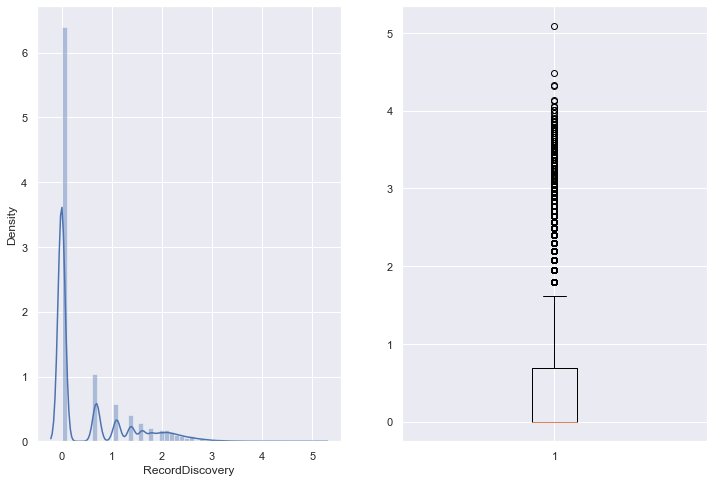


----- RecordEntertainment -----
count    158981.000000
mean          0.579802
std           0.907028
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.393628
Name: RecordEntertainment, dtype: float64
* Variance: 0.8226997387940422
* Median: 0.0
* Skewness: 1.498854583336848
* Kurtosis: 1.4048804167049336
* Percentage of outliers: 0.03624332467401765
* Number of missing value: 0


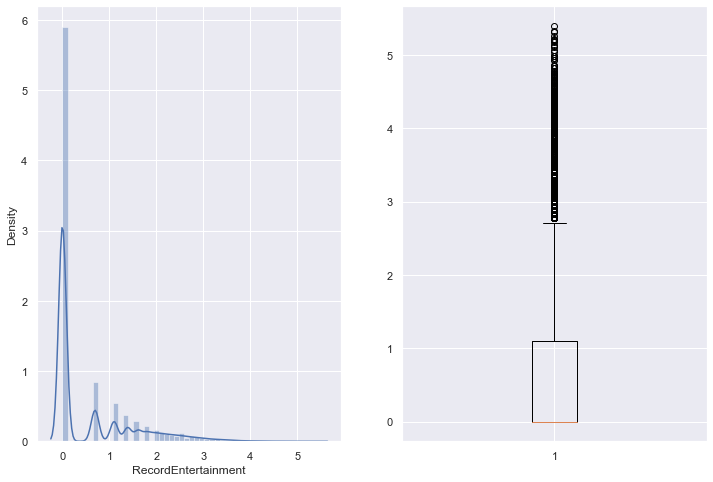


----- RecordLearn -----
count    158981.000000
mean          2.245484
std           1.156521
min           0.000000
25%           1.386294
50%           2.302585
75%           3.091042
max           6.063785
Name: RecordLearn, dtype: float64
* Variance: 1.3375406602944038
* Median: 2.302585092994046
* Skewness: -0.09998235957227893
* Kurtosis: -0.712537005191439
* Percentage of outliers: 0.00010693101691397086
* Number of missing value: 0


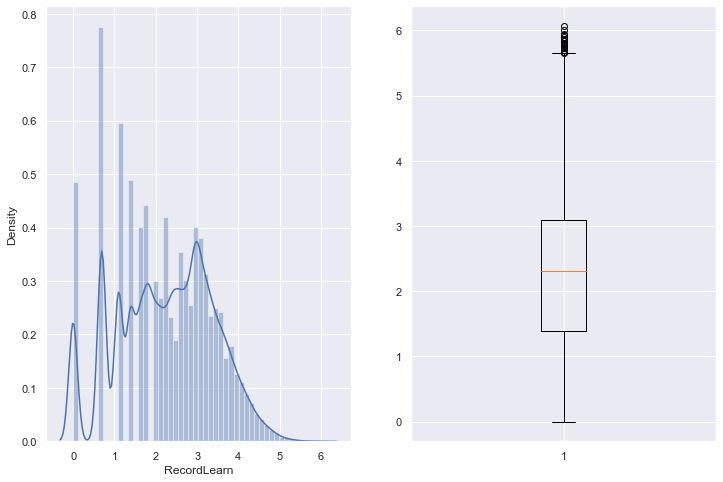


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.658814
std           1.077722
min           0.000000
25%           0.000000
50%           0.000000
75%           1.275363
max           5.818360
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.1614843446912997
* Median: 0.0
* Skewness: 1.3930481321770956
* Kurtosis: 0.5670109113660735
* Percentage of outliers: 0.03421792541247067
* Number of missing value: 0


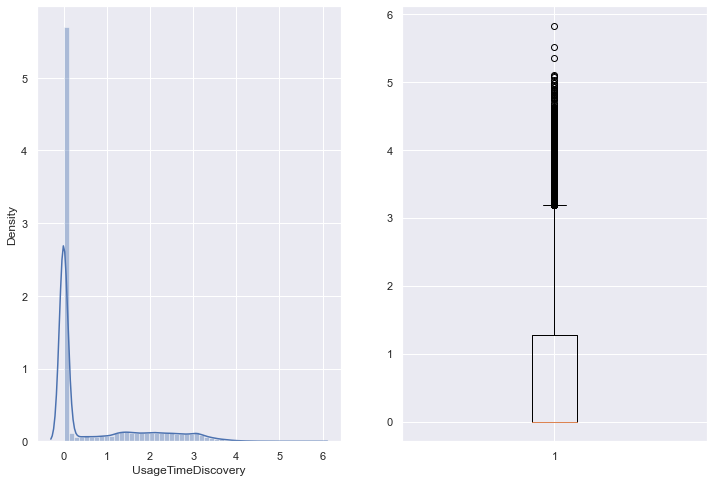


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.643759
std           1.112645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.928219
max           6.057908
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.2379786785257563
* Median: 0.0
* Skewness: 1.7066184300094955
* Kurtosis: 1.8669038991553966
* Percentage of outliers: 0.1199954711569307
* Number of missing value: 0


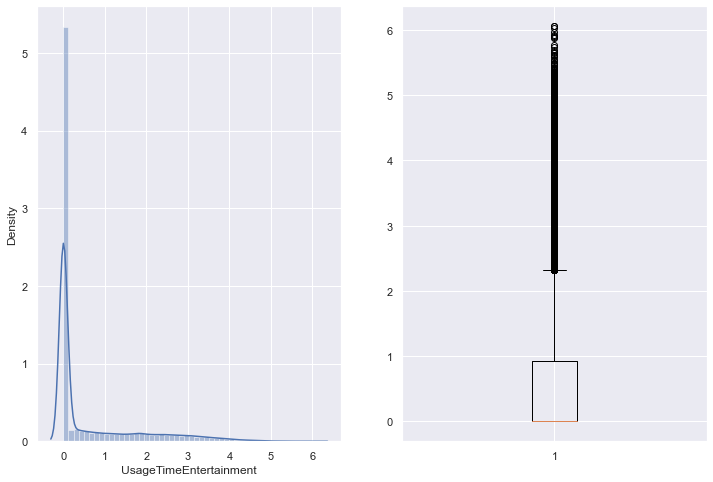


----- UsageTimeLearn -----
count    158981.000000
mean          2.055482
std           1.162421
min           0.000000
25%           1.115142
50%           2.131797
75%           2.931727
max           7.020218
Name: UsageTimeLearn, dtype: float64
* Variance: 1.3512227803676224
* Median: 2.131796772013764
* Skewness: -0.0167219595302974
* Kurtosis: -0.8047423942270049
* Percentage of outliers: 0.00020757197400947283
* Number of missing value: 0


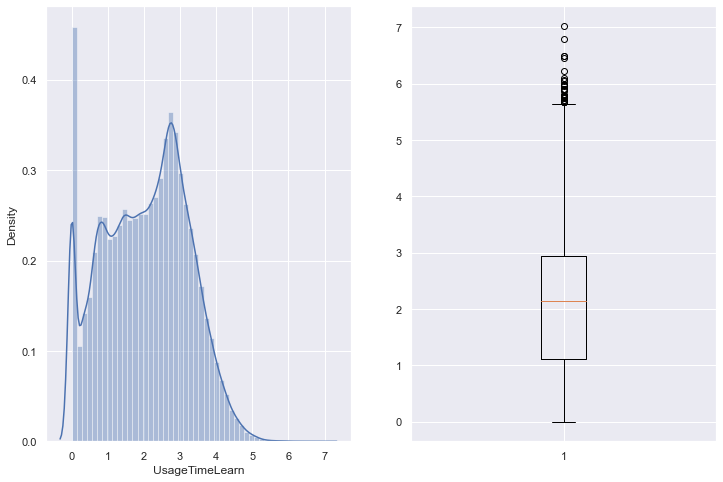


----- MedianUsageTime -----
count    158981.000000
mean          1.877883
std           0.867141
min           0.000000
25%           1.208960
50%           1.915451
75%           2.529322
max           6.095104
Name: MedianUsageTime, dtype: float64
* Variance: 0.7519330801764769
* Median: 1.9154509415706047
* Skewness: 0.010963593861537193
* Kurtosis: -0.6370103030583034
* Percentage of outliers: 0.0006919065800315761
* Number of missing value: 0


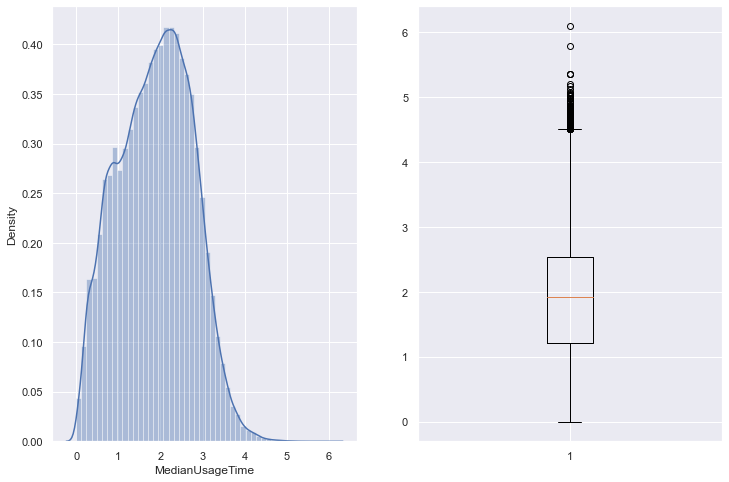


----- MedianRecord -----
count    158981.000000
mean          1.668420
std           0.976040
min           0.000000
25%           1.098612
50%           1.704748
75%           2.397895
max           5.262690
Name: MedianRecord, dtype: float64
* Variance: 0.9526535544278487
* Median: 1.7047480922384253
* Skewness: -0.017865539969934126
* Kurtosis: -0.670330437036581
* Percentage of outliers: 0.0009057686138595178
* Number of missing value: 0


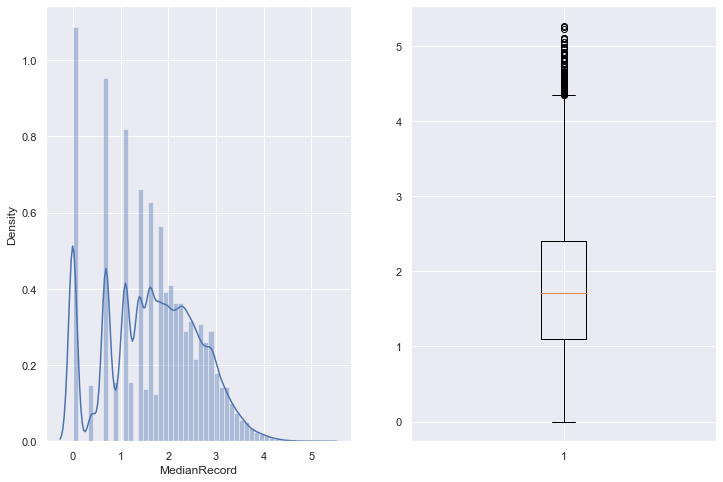


----- MedianPaymentScreen -----
count    158981.000000
mean          0.483489
std           0.697152
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.48602105182098876
* Median: 0.0
* Skewness: 1.4285673224573403
* Kurtosis: 1.5715664888185246
* Percentage of outliers: 0.07227278731420736
* Number of missing value: 0


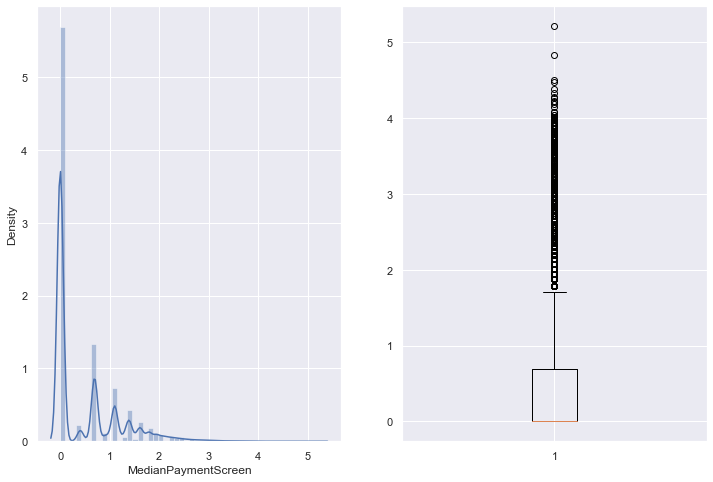


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.669991
std           0.257809
min           0.000000
25%           0.516808
50%           0.625938
75%           0.787922
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06646527967773917
* Median: 0.6259384308664954
* Skewness: 1.210342248689603
* Kurtosis: 3.8025228996084492
* Percentage of outliers: 0.046672243853039044
* Number of missing value: 0


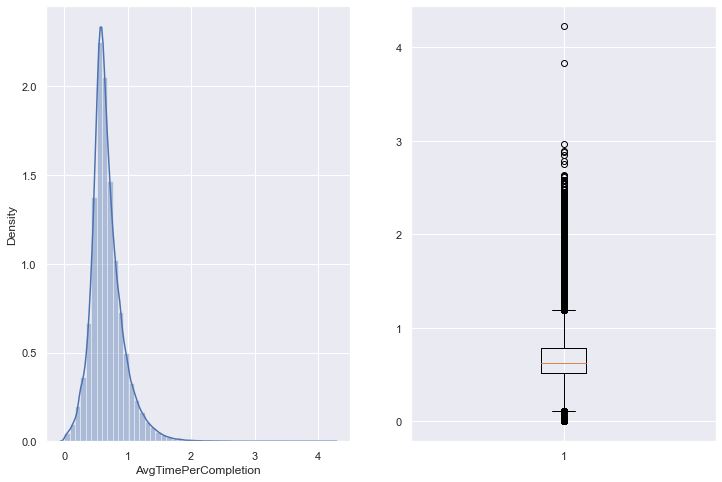


----- InteractionGeneral -----
count    158981.000000
mean          4.714508
std           2.432010
min           0.000000
25%           2.809403
50%           4.955264
75%           6.576470
max          12.731358
Name: InteractionGeneral, dtype: float64
* Variance: 5.914670241046202
* Median: 4.955263518561269
* Skewness: -0.12087207823359727
* Kurtosis: -0.8704138743814958
* Percentage of outliers: 2.5160239273875493e-05
* Number of missing value: 0


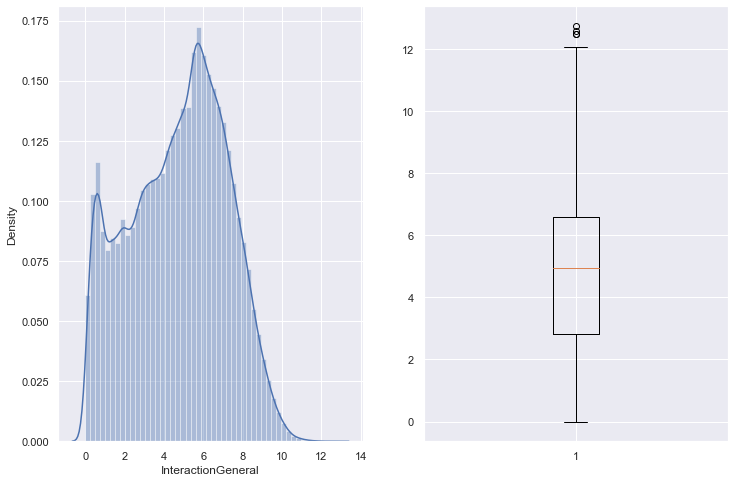


----- InteractionLearn -----
count    158981.000000
mean          4.029906
std           2.463472
min           0.000000
25%           1.934416
50%           4.224203
75%           5.927992
max          12.440142
Name: InteractionLearn, dtype: float64
* Variance: 6.06869639913329
* Median: 4.224202549480315
* Skewness: -0.018227029075790758
* Kurtosis: -0.9712482808446339
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


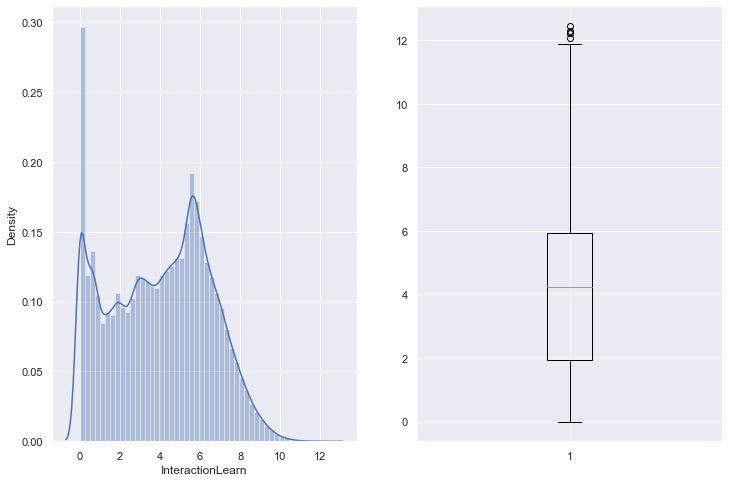


----- InteractionDiscovery -----
count    158981.000000
mean          1.003362
std           1.746340
min           0.000000
25%           0.000000
50%           0.000000
75%           1.427916
max          10.132911
Name: InteractionDiscovery, dtype: float64
* Variance: 3.049702468304741
* Median: 0.0
* Skewness: 1.6438049684532736
* Kurtosis: 1.4953627214209555
* Percentage of outliers: 0.12843673143331594
* Number of missing value: 0


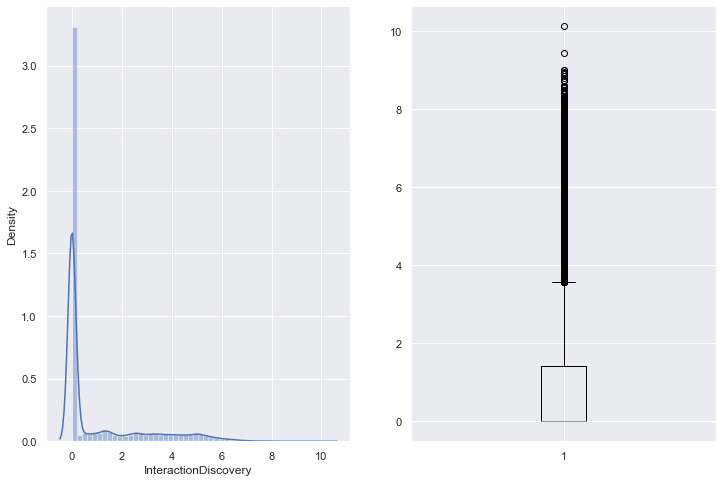


----- InteractionEntertainment -----
count    158981.000000
mean          1.061911
std           1.904856
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max          11.368783
Name: InteractionEntertainment, dtype: float64
* Variance: 3.6284760295642275
* Median: 0.0
* Skewness: 1.8303059839032114
* Kurtosis: 2.4148420903395507
* Percentage of outliers: 0.13978399934583377
* Number of missing value: 0


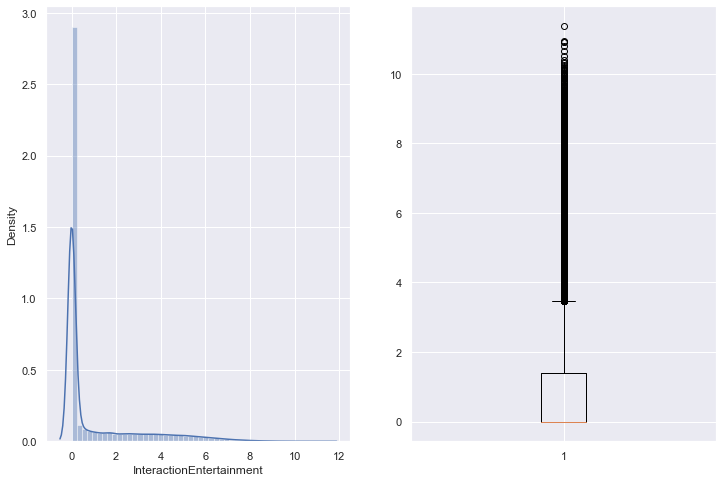


----- MedianInteraction -----
count    158981.000000
mean          3.427440
std           1.813382
min           0.000000
25%           1.987874
50%           3.478158
75%           4.794633
max          10.675204
Name: MedianInteraction, dtype: float64
* Variance: 3.288354496920597
* Median: 3.4781584227982836
* Skewness: 0.06385424705577115
* Kurtosis: -0.7394882807755141
* Percentage of outliers: 0.0003333731703788503
* Number of missing value: 0


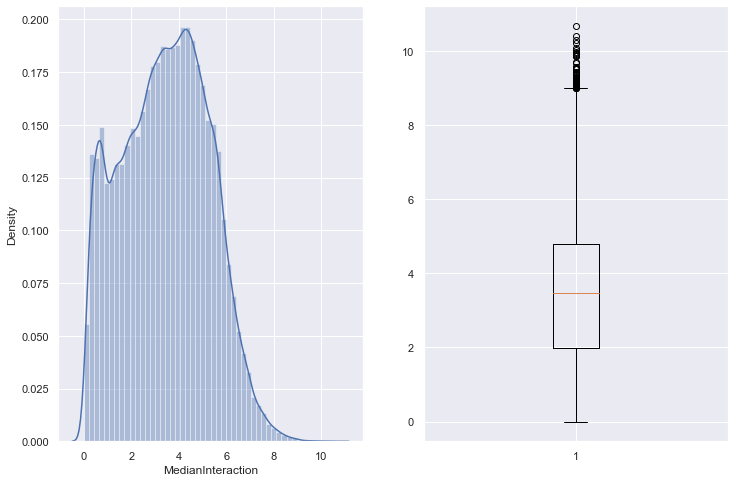

In [42]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   TotalChild                158981 non-null  float64
 7   MedianChildAge            158981 non-null  float64
 8   No.Female                 158981 non-null  float64
 9   No.Male                   158981 non-null  float64
 10  No.TypeBrand              158981 non-null  int64  
 11  BigBrand                  158981 non-null  float64
 12  MediumBrand               158981 non-null  float64
 13  SmallBrand                158981 non-null  f

In [283]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data['Label']

In [284]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [285]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [286]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [287]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9383884765379293

In [288]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9396

* Confusion Matrix: 
[[29646    91]
 [ 1831   229]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.72      0.11      0.19      2060

    accuracy                           0.94     31797
   macro avg       0.83      0.55      0.58     31797
weighted avg       0.93      0.94      0.92     31797



In [289]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9210356648635049

In [290]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9168

* Confusion Matrix: 
[[28167  1570]
 [ 1074   986]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.39      0.48      0.43      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.71      0.69     31797
weighted avg       0.93      0.92      0.92     31797



In [291]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9493568373380299

In [292]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9232

* Confusion Matrix: 
[[28471  1266]
 [ 1175   885]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.41      0.43      0.42      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.69      0.69     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6935


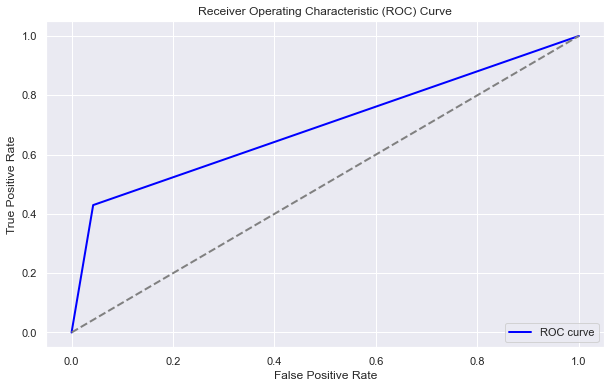

In [293]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [294]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9265001887029815

In [295]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9192

* Confusion Matrix: 
[[28255  1482]
 [ 1088   972]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.40      0.47      0.43      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.71      0.69     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7110


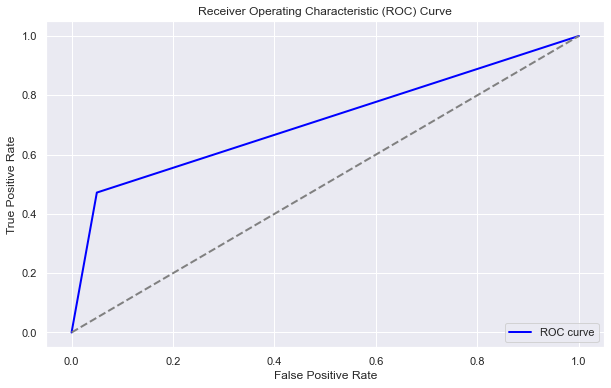

In [296]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [297]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9341426594540194

In [298]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9287

* Confusion Matrix: 
[[28673  1064]
 [ 1202   858]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.45      0.42      0.43      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.69      0.70     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.6904


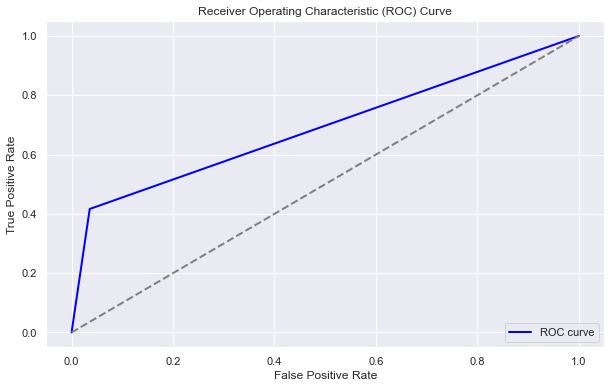

In [299]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [300]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8218014844634545

In [301]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8094

* Confusion Matrix: 
[[24361  5376]
 [  684  1376]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     29737
           1       0.20      0.67      0.31      2060

    accuracy                           0.81     31797
   macro avg       0.59      0.74      0.60     31797
weighted avg       0.92      0.81      0.85     31797



ROC AUC score: 0.7436


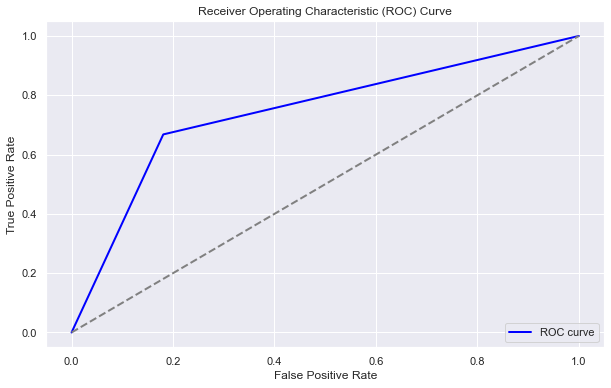

In [302]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [303]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9204145175493773

In [304]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9166

* Confusion Matrix: 
[[28158  1579]
 [ 1074   986]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.38      0.48      0.43      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.71      0.69     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7128


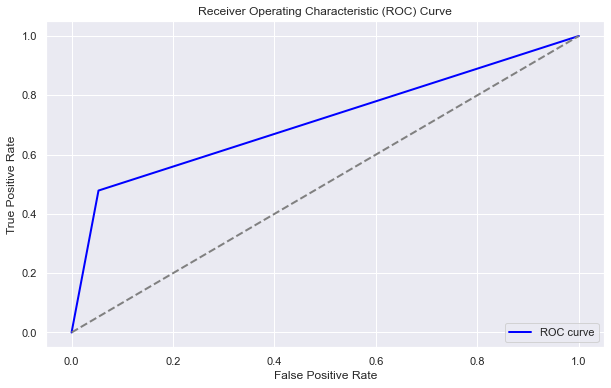

In [305]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [306]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.7877091458045037

In [307]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7878

* Confusion Matrix: 
[[23864  5873]
 [  873  1187]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.80      0.88     29737
           1       0.17      0.58      0.26      2060

    accuracy                           0.79     31797
   macro avg       0.57      0.69      0.57     31797
weighted avg       0.91      0.79      0.84     31797



In [308]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

0.9999764121273116

In [309]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8959

* Confusion Matrix: 
[[27933  1804]
 [ 1507   553]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     29737
           1       0.23      0.27      0.25      2060

    accuracy                           0.90     31797
   macro avg       0.59      0.60      0.60     31797
weighted avg       0.90      0.90      0.90     31797



In [186]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [170]:
sw_zen

array([0.535, 7.717])

In [168]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7490564850924645

In [169]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7525

* Confusion Matrix: 
[[22487  7250]
 [  621  1439]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     29737
           1       0.17      0.70      0.27      2060

    accuracy                           0.75     31797
   macro avg       0.57      0.73      0.56     31797
weighted avg       0.92      0.75      0.81     31797



In [171]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7531214618190968

In [172]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7552

* Confusion Matrix: 
[[22586  7151]
 [  632  1428]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     29737
           1       0.17      0.69      0.27      2060

    accuracy                           0.76     31797
   macro avg       0.57      0.73      0.56     31797
weighted avg       0.92      0.76      0.82     31797



In [173]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9253443829412504

In [174]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9277

* Confusion Matrix: 
[[28853   884]
 [ 1415   645]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29737
           1       0.42      0.31      0.36      2060

    accuracy                           0.93     31797
   macro avg       0.69      0.64      0.66     31797
weighted avg       0.92      0.93      0.92     31797



In [175]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9381054220656686

In [176]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9397

* Confusion Matrix: 
[[29500   237]
 [ 1681   379]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.62      0.18      0.28      2060

    accuracy                           0.94     31797
   macro avg       0.78      0.59      0.63     31797
weighted avg       0.92      0.94      0.92     31797



In [177]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

0.9997405334004277

In [178]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9041

* Confusion Matrix: 
[[28253  1484]
 [ 1566   494]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.25      0.24      0.24      2060

    accuracy                           0.90     31797
   macro avg       0.60      0.59      0.60     31797
weighted avg       0.90      0.90      0.90     31797



In [179]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

0.9997405334004277

In [180]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9024

* Confusion Matrix: 
[[28206  1531]
 [ 1573   487]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.24      0.24      0.24      2060

    accuracy                           0.90     31797
   macro avg       0.59      0.59      0.59     31797
weighted avg       0.90      0.90      0.90     31797



In [181]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

0.9997641212731161

In [182]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8998

* Confusion Matrix: 
[[28089  1648]
 [ 1539   521]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     29737
           1       0.24      0.25      0.25      2060

    accuracy                           0.90     31797
   macro avg       0.59      0.60      0.60     31797
weighted avg       0.90      0.90      0.90     31797



In [187]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

0.9997405334004277

In [188]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8997

* Confusion Matrix: 
[[28110  1627]
 [ 1561   499]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.23      0.24      0.24      2060

    accuracy                           0.90     31797
   macro avg       0.59      0.59      0.59     31797
weighted avg       0.90      0.90      0.90     31797



In [189]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9997248081519688

In [190]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.941

* Confusion Matrix: 
[[29591   146]
 [ 1730   330]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.69      0.16      0.26      2060

    accuracy                           0.94     31797
   macro avg       0.82      0.58      0.61     31797
weighted avg       0.93      0.94      0.92     31797



In [191]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.999693357655051

In [192]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9409

* Confusion Matrix: 
[[29621   116]
 [ 1762   298]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.72      0.14      0.24      2060

    accuracy                           0.94     31797
   macro avg       0.83      0.57      0.61     31797
weighted avg       0.93      0.94      0.92     31797



In [310]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9325937224808152

In [311]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9289

* Confusion Matrix: 
[[28673  1064]
 [ 1198   862]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.45      0.42      0.43      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.69      0.70     31797
weighted avg       0.93      0.93      0.93     31797



In [312]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [313]:
class_weights_dict = dict(enumerate(class_weights))

In [314]:
class_weights_dict

{0: 0.5346379160753559, 1: 7.717524271844661}

In [315]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8159045162913574

In [316]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8064

* Confusion Matrix: 
[[24255  5482]
 [  675  1385]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     29737
           1       0.20      0.67      0.31      2060

    accuracy                           0.81     31797
   macro avg       0.59      0.74      0.60     31797
weighted avg       0.92      0.81      0.85     31797



In [235]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.953146622216631

In [236]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9424

* Confusion Matrix: 
[[29560   177]
 [ 1654   406]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.70      0.20      0.31      2060

    accuracy                           0.94     31797
   macro avg       0.82      0.60      0.64     31797
weighted avg       0.93      0.94      0.93     31797



In [237]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.928615234620707

In [238]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9158

* Confusion Matrix: 
[[28217  1520]
 [ 1157   903]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.37      0.44      0.40      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.69      0.68     31797
weighted avg       0.92      0.92      0.92     31797



In [239]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [242]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9822983925208502

In [243]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9673

* Confusion Matrix: 
[[115965   2979]
 [  1182   7058]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    118944
           1       0.70      0.86      0.77      8240

    accuracy                           0.97    127184
   macro avg       0.85      0.92      0.88    127184
weighted avg       0.97      0.97      0.97    127184



In [244]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9143

* Confusion Matrix: 
[[28296  1441]
 [ 1285   775]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.35      0.38      0.36      2060

    accuracy                           0.91     31797
   macro avg       0.65      0.66      0.66     31797
weighted avg       0.92      0.91      0.92     31797



In [247]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.8994652945924132

In [248]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8126

* Confusion Matrix: 
[[24599  5138]
 [  822  1238]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     29737
           1       0.19      0.60      0.29      2060

    accuracy                           0.81     31797
   macro avg       0.58      0.71      0.59     31797
weighted avg       0.92      0.81      0.85     31797

